# walkthrough of an vine copula (vinecop) application on financial (US ETFs) dependence modeling and simulation.

- data preprocessing and exploratory data analysis
- make marginal cdf/ppf, transform from raw return to copula data
- fit 'rvine', draw, do full simulation
- fit 'cvine', draw, do cond simulation (given **SPY** scenario)


## initialization, fetch data, preprocess


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yfinance as yf

import torchvinecopulib as tvc

lst_ticker = [
    "SPY",
    "QQQ",
    "DIA",
    "IJH",
    "VTI",
    "IWM",
    "XLF",
    "XLE",
    "XLK",
    "EFA",
    "EWA",
    "EWJ",
    "EEM",
    "FXI",
    "AGG",
    "TLT",
    "GLD",
    "SLV",
    "USO",
    "UNG",
]
print(lst_ticker)
raw_df = yf.download(lst_ticker, start="2010-01-01")
raw_df.index = pd.DatetimeIndex(raw_df.index)
raw_df = raw_df["Adj Close"].ffill()
# calc simple retn
NUM_DAY_INTVL = 1
df_retn_adjclose_simple_last_intvl = np.expm1(np.log(raw_df)[::NUM_DAY_INTVL].diff(1).dropna())
#
NUM_SIM = 50000
print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

['SPY', 'QQQ', 'DIA', 'IJH', 'VTI', 'IWM', 'XLF', 'XLE', 'XLK', 'EFA', 'EWA', 'EWJ', 'EEM', 'FXI', 'AGG', 'TLT', 'GLD', 'SLV', 'USO', 'UNG']


[*********************100%%**********************]  20 of 20 completed


cuda (GPU) avail? True



### chart rolling bidep between each asset and SPY


In [2]:
f_bidep = lambda a, b: tvc.util.kendall_tau(a, b)[0]
dct_dep_spy = {}
for df in df_retn_adjclose_simple_last_intvl.rolling(
    window=252 // NUM_DAY_INTVL, step=int(np.sqrt(252) // NUM_DAY_INTVL)
):
    if df.shape[0] >= 252 // NUM_DAY_INTVL:
        dct_dep_spy[df.index[-1]] = {
            k: f_bidep(torch.from_numpy(df[[k]].values), torch.from_numpy(df[["SPY"]].values))
            for k in df.keys()
        }

Text(0.5, 1.0, 'Rolling bivariate dependence (<lambda>), between ETFs and SPY.')

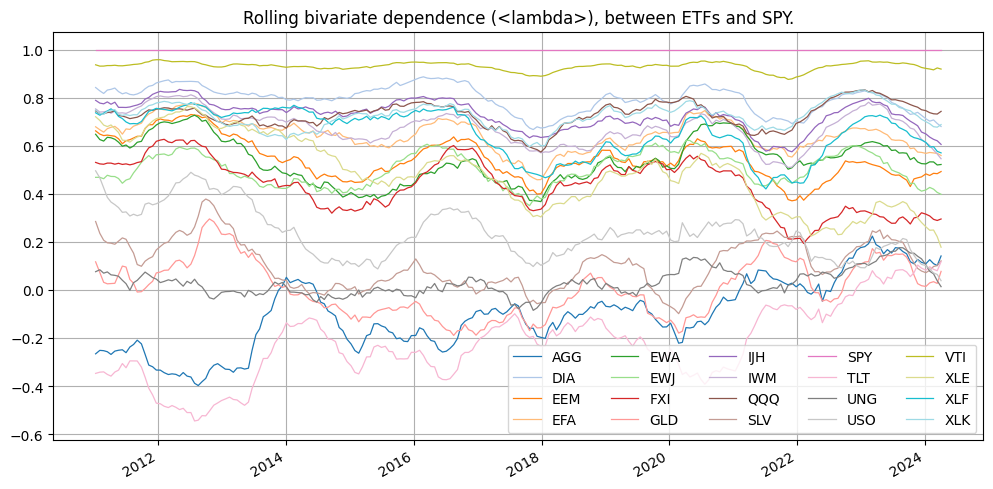

In [3]:
pd.DataFrame(dct_dep_spy).T.plot(figsize=(12, 6), style="-", alpha=1, lw=0.9, colormap="tab20")
plt.legend(ncol=5)
plt.grid()
plt.title(f"Rolling bivariate dependence ({f_bidep.__name__}), between ETFs and SPY.")

### make marginal cdf_ppf functions; transform from raw data (-∞,∞)-> copula data (0,1)


In [4]:
from scipy import stats
from random import seed as r_seed
from scipy.special import ndtr
from scipy.interpolate import CubicSpline


def make_cdf_ppf(
    vec_obs: np.array,
    mtd_margin: str,
    seed: int,
    lst_distribution: list = [
        stats.t,
        stats.nct,
        stats.johnsonsu,
        stats.tukeylambda,
    ],
) -> pd.Series:
    """fit marginal univariate distributions, return fitted cdf/ppf functions
    # ! band_width for np fit from:
    Dhaker, H., Deme, E. H., & Ciss, Y. (2021).
    β-Divergence loss for the kernel density estimation with bias reduced.
    Statistical Theory and Related Fields, 5(3), 221-231.
    """
    r_seed(seed)
    np.random.seed(seed=seed)
    vec_clean = np.sort(vec_obs[np.isfinite(vec_obs)])
    if mtd_margin == "np":
        # The constant has beta = 1.7320508075688772 from
        # (4 * beta**4 / (9 * beta**4 - 36 * beta**3 + 90 * beta**2 + 270 * beta + 105) * sqrt(2 / pi))**(1 / 9)
        band_width = vec_clean.std() * 0.6973425390765554 * (len(vec_clean)) ** (-1 / 9)

        # empirical cdf, semi parametric approach, from mixture
        @np.vectorize
        def res_cdf(quantile: np.array):
            # ±∞ return to (0,1) cdf
            return ndtr((quantile - vec_clean) / band_width).mean()

        vec_F, idx = np.unique(res_cdf(vec_clean), return_index=True)
        func_spline = CubicSpline(x=vec_F, y=vec_clean[idx])

        def res_ppf(percentage: np.array):
            # (0,1) cdf to ±∞ return
            return func_spline(percentage)

    elif mtd_margin == "p":
        dist, par, bic2, lnn2 = None, None, np.inf, np.log(len(vec_clean)) / 2
        for iter_dist in lst_distribution:
            iter_par = iter_dist.fit(vec_clean)
            iter_bic2 = len(iter_par) * lnn2 - iter_dist.logpdf(vec_clean, *iter_par).sum()
            if iter_bic2 < bic2:
                dist, par, bic2 = iter_dist, iter_par, iter_bic2
        res_cdf, res_ppf = lambda vec: dist.cdf(vec, *par), lambda vec: dist.ppf(vec, *par)

    return pd.Series({"cdf": res_cdf, "ppf": res_ppf})

In [5]:
arr_cdf_ppf = np.apply_along_axis(
    func1d=lambda vec: make_cdf_ppf(vec_obs=vec, mtd_margin="np", seed=0),
    axis=0,
    arr=df_retn_adjclose_simple_last_intvl.values,
)

In [6]:
V_mvcp = torch.as_tensor(
    np.hstack(
        [
            cdf(df_retn_adjclose_simple_last_intvl.values[:, [idx]])
            for idx, cdf in enumerate(arr_cdf_ppf[0])
        ]
    ),
    device=DEVICE,
)
print(V_mvcp.min(), V_mvcp.max())

tensor(0.0001, device='cuda:0', dtype=torch.float64) tensor(0.9999, device='cuda:0', dtype=torch.float64)


## dvine, full sim
> make dvine from multivariate copula observations, **full sim**

In [7]:
# read tpl_sim from right to left
mdl_vcp = tvc.vinecop.vcp_from_obs(V_mvcp)

print(mdl_vcp)

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 20,
 'num_obs': 3_598,
 'num_par': 127,
 'negloglik': -56387.4357,
 'aic': -112520.8714,
 'bic': -111734.9785,
 'matrix': '[[ 6 14 15 17  9  0 13  8 19 10 18  1 12  7 16 11  5  4  3  2]'
           ' [-1  5 14 15 17  9  0 13  8 19 10 18  1 12  7 16 11  4  2  3]'
           ' [-1 -1 14 15 17  9  7 11  4  8  2  3 16 19 10 12  1 18  0 13]'
           ' [-1 -1 -1  0 15 17  9  7 11  4  8  2  3 16 19 10 12  1 18 13]'
           ' [-1 -1 -1 -1 13 15 17  9  7 11  4  8  2  3 16 19 10 12  1 18]'
           ' [-1 -1 -1 -1 -1  7 15 17  9  8 19 10 18  1 12 16  2  3  4 11]'
           ' [-1 -1 -1 -1 -1 -1 11 15 17  9  8 19 10 18  1 12 16  2  3  4]'
           ' [-1 -1 -1 -1 -1 -1 -1  4 15 17  9  8 19 10 18  1 12 16  2  3]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 15 19  2  3 10 18  1 12  9 16  8 17]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 17 19  2  3 10 18  1 12  9 16  8]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  9 19  2  3 10 18  1 12 16  8]'
          

In [8]:
for _ in enumerate(df_retn_adjclose_simple_last_intvl.columns):
    print(_)

(0, 'AGG')
(1, 'DIA')
(2, 'EEM')
(3, 'EFA')
(4, 'EWA')
(5, 'EWJ')
(6, 'FXI')
(7, 'GLD')
(8, 'IJH')
(9, 'IWM')
(10, 'QQQ')
(11, 'SLV')
(12, 'SPY')
(13, 'TLT')
(14, 'UNG')
(15, 'USO')
(16, 'VTI')
(17, 'XLE')
(18, 'XLF')
(19, 'XLK')


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 0, BiDep Metric chatterjee_xi'}>,
 <networkx.classes.graph.Graph at 0x26e86f8f1c0>)

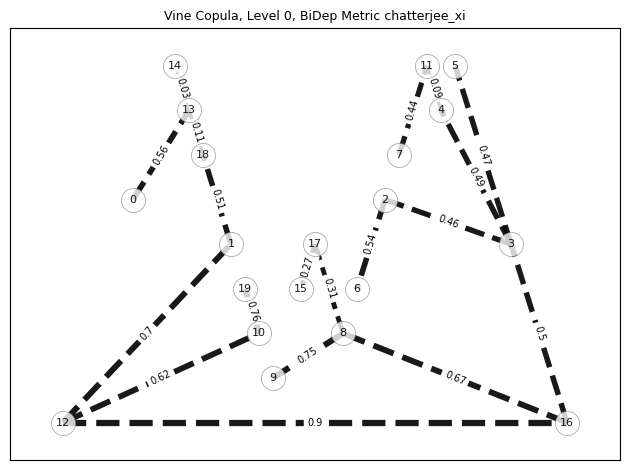

In [9]:
# SPY is vertex 12
mdl_vcp.draw_lv()

In [10]:
print(mdl_vcp.tpl_sim)
V_sim = mdl_vcp.sim(num_sim=NUM_SIM, device=DEVICE)
print(V_sim)

(6, 5, 14, 0, 13, 7, 11, 4, 15, 17, 9, 8, 2, 3, 16, 18, 1, 12, 10, 19)
tensor([[0.3417, 0.7795, 0.9284,  ..., 0.9555, 0.9268, 0.8805],
        [0.9744, 0.8067, 0.4781,  ..., 0.7377, 0.2997, 0.6501],
        [0.1129, 0.3703, 0.8158,  ..., 0.4413, 0.5790, 0.4968],
        ...,
        [0.3802, 0.6955, 0.7016,  ..., 0.6538, 0.2038, 0.9686],
        [0.7754, 0.1502, 0.5077,  ..., 0.0710, 0.3769, 0.1111],
        [0.1647, 0.3182, 0.4630,  ..., 0.3710, 0.2060, 0.3140]],
       device='cuda:0', dtype=torch.float64)


In [11]:
arr_sim = np.hstack([ppf(V_sim[:, [idx]].cpu()) for idx, ppf in enumerate(arr_cdf_ppf[1])])

print(arr_sim.min(), arr_sim.max())
print(
    "\nkendall tau wrt SPY, of simulations",
    pd.DataFrame(arr_sim, columns=df_retn_adjclose_simple_last_intvl.columns).corr(
        method="kendall"
    )["SPY"],
)
print(
    "\nkendall tau wrt SPY, of raw obs",
    df_retn_adjclose_simple_last_intvl.corr(method="kendall")["SPY"],
)

-0.2575949920252931 0.319113808246726

kendall tau wrt SPY, of simulations Ticker
AGG   -0.091771
DIA    0.791261
EEM    0.552741
EFA    0.642946
EWA    0.561390
EWJ    0.502631
FXI    0.429395
GLD    0.039564
IJH    0.724163
IWM    0.672896
QQQ    0.734092
SLV    0.136018
SPY    1.000000
TLT   -0.217810
UNG    0.029148
USO    0.254959
VTI    0.931329
XLE    0.479137
XLF    0.653642
XLK    0.721009
Name: SPY, dtype: float64

kendall tau wrt SPY, of raw obs Ticker
AGG   -0.083352
DIA    0.794358
EEM    0.548962
EFA    0.645093
EWA    0.548992
EWJ    0.500954
FXI    0.429852
GLD    0.023401
IJH    0.724957
IWM    0.674827
QQQ    0.735547
SLV    0.128756
SPY    1.000000
TLT   -0.208822
UNG    0.037993
USO    0.233810
VTI    0.932024
XLE    0.467534
XLF    0.646473
XLK    0.724877
Name: SPY, dtype: float64


## rvine, cond sim
> make rvine from multivariate copula observations, **cond sim**

In [12]:
# user specify the priority vertices list, used in fitting and also in the conditional simulation
mdl_vcp_cond = tvc.vinecop.vcp_from_obs(
    V_mvcp,
    mtd_vine="rvine",
    tpl_first=(12,),
)

print(mdl_vcp_cond)

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 20,
 'num_obs': 3_598,
 'num_par': 127,
 'negloglik': -56387.4357,
 'aic': -112520.8714,
 'bic': -111734.9785,
 'matrix': '[[ 6 14 15 17  9  0 13  8 19 10 18  1 12  7 16 11  5  4  3  2]'
           ' [-1  5 14 15 17  9  0 13  8 19 10 18  1 12  7 16 11  4  2  3]'
           ' [-1 -1 14 15 17  9  7 11  4  8  2  3 16 19 10 12  1 18  0 13]'
           ' [-1 -1 -1  0 15 17  9  7 11  4  8  2  3 16 19 10 12  1 18 13]'
           ' [-1 -1 -1 -1 13 15 17  9  7 11  4  8  2  3 16 19 10 12  1 18]'
           ' [-1 -1 -1 -1 -1  7 15 17  9  8 19 10 18  1 12 16  2  3  4 11]'
           ' [-1 -1 -1 -1 -1 -1 11 15 17  9  8 19 10 18  1 12 16  2  3  4]'
           ' [-1 -1 -1 -1 -1 -1 -1  4 15 17  9  8 19 10 18  1 12 16  2  3]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 15 19  2  3 10 18  1 12  9 16  8 17]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 17 19  2  3 10 18  1 12  9 16  8]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  9 19  2  3 10 18  1 12 16  8]'
          

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 0, BiDep Metric chatterjee_xi'}>,
 <networkx.classes.graph.Graph at 0x26e870de3e0>)

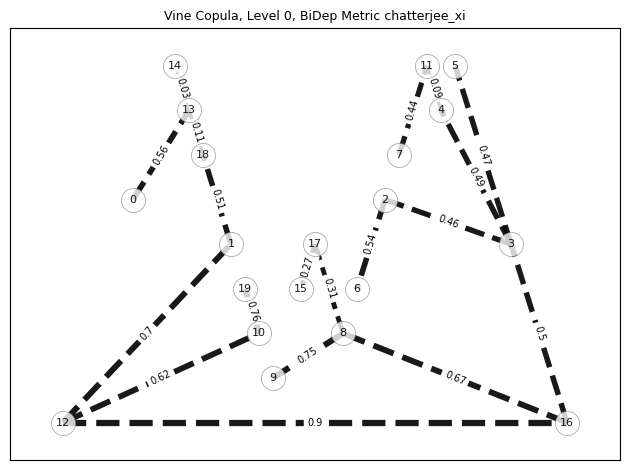

In [13]:
# SPY is vertex 12
mdl_vcp_cond.draw_lv()

In [14]:
# cond sim: user specified values for first set (vertex 12),
# a tail scenario with CDF(SPY)=.05
dct_first_vs = {(12, frozenset()): torch.ones(size=(NUM_SIM, 1), device=DEVICE) * (0.05)}
V_sim_cond = mdl_vcp.sim(num_sim=NUM_SIM, dct_first_vs=dct_first_vs, device=DEVICE)
arr_sim_cond = np.hstack(
    [ppf(V_sim_cond[:, [idx]].cpu()) for idx, ppf in enumerate(arr_cdf_ppf[1])]
)
print("specified value of SPY:", arr_sim_cond[:, 12])
print(arr_sim_cond[:3, :])

specified value of SPY: [-0.01723478 -0.01723478 -0.01723478 ... -0.01723478 -0.01723478
 -0.01723478]
[[ 1.44585645e-04 -2.79893504e-02 -2.77600475e-02 -8.11477310e-02
  -7.37900946e-02 -4.24869182e-02 -3.23256639e-02 -1.15442582e-02
  -1.81310349e-02 -7.75054183e-03  2.06980907e-02 -8.35495193e-02
  -1.72347817e-02  6.31587886e-03 -5.75790500e-03 -1.81032415e-01
  -1.34192287e-02 -4.84608732e-02 -1.18653434e-01  1.40940966e-02]
 [ 3.36582097e-03 -1.72151124e-02 -3.42068261e-03 -4.72109539e-02
  -3.43341670e-02 -2.24323292e-02  1.00711980e-02  1.76191577e-02
  -1.91689080e-02 -1.73926846e-02 -6.42385869e-03  9.98926334e-03
  -1.72347817e-02  1.82048346e-02  4.63616326e-02  6.90078959e-03
  -1.67271539e-02 -1.29175612e-02 -2.29159312e-02 -7.80794219e-03]
 [ 3.70118735e-04 -1.91158856e-02 -8.78561574e-03 -2.26502717e-02
  -1.96858806e-02 -3.60066964e-02 -6.41348001e-03  2.25387960e-03
  -3.00704357e-02 -2.57643134e-02 -2.23900008e-03 -1.85073453e-03
  -1.72347817e-02  1.64499682e-03 -1.